In [1]:
import rbo
import pandas as pd
import numpy as np

In [2]:
# parameters
hash_function = "murmur2"

baseline_recommendations_path = "../data/baseline_recommendations.json"
single_partition_recommendations_path = "../data/single_recommendations.json"
recommendations_path = f"../data/{hash_function}_recommendations.json"
merge_recommendations_path = f"../data/{hash_function}_merge_recommendations.json"
best_partition_recommendations_path = f"../data/{hash_function}_best_partition_recommendations.json"
highest_degree_recommendations_path = f"../data/{hash_function}_highest_degree_recommendations.json"

show_partitions = True
show_merge_1 = True
show_merge_2 = True
show_merge_3 = True

users = "../data/users.json"
output_rbo = f"../data/{hash_function}_rbo@k.json"
output_diagram = f"../output/{hash_function}_rbo@k.png"
output_rbo_at_k = f"../output/{hash_function}_rbo@k.csv"

In [3]:
# Read data
baseline_df = pd.read_json(baseline_recommendations_path, orient="table")
single_partition_recommendations_df = pd.read_json(single_partition_recommendations_path, orient="table")

merge_recommendations_df = pd.read_json(merge_recommendations_path, orient="table")
partitioned_recommendations_df = pd.read_json(recommendations_path, orient="table")
partitioned_recommendations_df["len_recommendations"] = partitioned_recommendations_df["recommendations"].str.len()
best_partition_recommendations_df = pd.read_json(best_partition_recommendations_path, orient="table")
highest_degree_recommendations_df = pd.read_json(highest_degree_recommendations_path, orient="table")

user_ids = pd.read_json(users, orient="table")["user_id"].values

In [9]:
def mean_rbo(actual, predicted, k):
    return np.mean([rbo.RankingSimilarity(a, p).rbo(k=k, p=1) for a, p in zip(actual, predicted)])

In [10]:
def calculate_rbo_k(df):
    list_actual = []
    list_prediction = []
    rows = []

    hash_fun = df["hash_function"].unique()[0]
    partitions = df["partition"].unique()
    partitions.sort()

    for partition in list(partitions):
        for k in range(1, 11):
            for _, uid in enumerate(user_ids):
                actual = baseline_df[baseline_df["user"] == uid]["recommendations"].values[0]

                con = (
                        (df["user"] == uid) &
                        (df["partition"] == partition)
                )

                try:
                    predicted = df[con]["recommendations"].values[0]

                    list_actual.append(actual)
                    list_prediction.append(predicted)
                except IndexError as error:
                    print(f"userID {uid}, partition {partition}, hash_function {hash_fun}")
                    exit(1)

            m = mean_rbo(list_actual, list_prediction, int(k))
            rows.append((hash_fun, partition, k, m))

            print(f"rbo@{k}: {m}    partition: {partition}    hash_function: {hash_fun}")

    return pd.DataFrame(rows, columns=["hash_function", "partition", "k", "rbo"])

In [11]:
# Calculate Mean RBO@K for Single, Multi partition, and merged
all_rbo_data_frames = []

rbo_single_df = calculate_rbo_k(single_partition_recommendations_df)
all_rbo_data_frames.append(rbo_single_df)

if show_partitions:
    rbo_partitions_df = calculate_rbo_k(partitioned_recommendations_df)
    all_rbo_data_frames.append(rbo_partitions_df)
if show_merge_1:
    rbo_merge_df = calculate_rbo_k(merge_recommendations_df)
    all_rbo_data_frames.append(rbo_merge_df)
if show_merge_2:
    rbo_best_partitions_df = calculate_rbo_k(best_partition_recommendations_df)
    all_rbo_data_frames.append(rbo_best_partitions_df)
if show_merge_3:
    rbo_highest_degree_partitions_df = calculate_rbo_k(highest_degree_recommendations_df)
    all_rbo_data_frames.append(rbo_highest_degree_partitions_df)

rbo_df = pd.concat(all_rbo_data_frames, ignore_index=True)
rbo_df.to_json(output_rbo, index=False, orient="table")

rbo@1: 0.1742    partition: partition    hash_function: Single
rbo@2: 0.22432999999999995    partition: partition    hash_function: Single
rbo@3: 0.27120199999999994    partition: partition    hash_function: Single
rbo@4: 0.31388494999999994    partition: partition    hash_function: Single
rbo@5: 0.35340841399999995    partition: partition    hash_function: Single
rbo@6: 0.38913305899999995    partition: partition    hash_function: Single
rbo@7: 0.42158132805714277    partition: partition    hash_function: Single
rbo@8: 0.4513074803921428    partition: partition    hash_function: Single
rbo@9: 0.4783025574281428    partition: partition    hash_function: Single
rbo@10: 0.5027952807427228    partition: partition    hash_function: Single
rbo@1: 0.0358    partition: 0    hash_function: murmur2
rbo@2: 0.04794999999999999    partition: 0    hash_function: murmur2
rbo@3: 0.05977599999999999    partition: 0    hash_function: murmur2
rbo@4: 0.0708568    partition: 0    hash_function: murmur2
rb

In [12]:
def draw_plot(rbo_df, plt):
    ax = plt.gca()

    hash_functions = rbo_df["hash_function"].unique()

    for func in list(hash_functions):
        df_partition = rbo_df[rbo_df["hash_function"] == func]

        partitions = df_partition["partition"].unique()
        partitions.sort()

        for partition in list(partitions):
            df = df_partition[df_partition["partition"] == partition]
            df.plot(x="k",
                    y='rbo',
                    kind="line",
                    title=f"Rank-Biased Overlap @ K for Increasing $K$ for {len(user_ids)} Users",
                    label=f"{func} {partition}",
                    marker='o',
                    ax=ax)

    ax.set_ylim([0, 1])
    ax.set_xlabel("K")
    ax.set_ylabel("RBO@K")
    ax.set_title(f"Rank-Biased Overlap @ K for Increasing $K$ for {len(user_ids)} Users")
    return plt

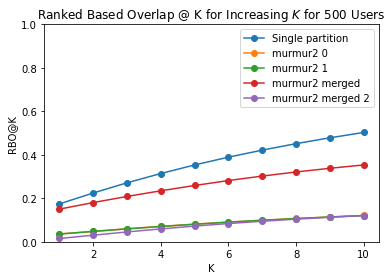

In [13]:
import matplotlib.pyplot as plt

plot = draw_plot(rbo_df, plt)
plot.savefig(output_diagram)

In [ ]:
rbo_df = rbo_df.reset_index(drop=True)
rbo_df.to_csv(output_rbo_at_k, index=True)